In [ ]:
!git clone https://github.com/ganeshmm/TamilNet.git

Cloning into 'TamilNet'...
remote: Enumerating objects: 83829, done.
remote: Counting objects: 100% (112/112), done.
remote: Compressing objects: 100% (84/84), done.
remote: Total 83829 (delta 42), reused 72 (delta 21), pack-reused 83717 (from 1)
Receiving objects: 100% (83829/83829), 92.25 MiB | 18.78 MiB/s, done.
Resolving deltas: 100% (1065/1065), done.
Updating files: 100% (238185/238185), done.


In [ ]:
from PIL import Image, ImageOps, ImageFilter
import numpy as np
from scipy import ndimage
from torchvision import datasets, transforms
import torch
import pandas as pd
import matplotlib.pyplot as plt
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from google.colab import files

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
class Process(object):
    def __call__(self, img):
        converted = img.convert("L")
        inverted = ImageOps.invert(converted)
        thick = inverted.filter(ImageFilter.MaxFilter(5))
        ratio = 48.0 / max(thick.size)
        new_size = tuple([int(round(x*ratio)) for x in thick.size])
        res = thick.resize(new_size, Image.LANCZOS)

        arr = np.asarray(res)
        com = ndimage.measurements.center_of_mass(arr)
        result = Image.new("L", (64, 64))
        box = (int(round(32.0 - com[1])), int(round(32.0 - com[0])))
        result.paste(res, box)
        return result

In [ ]:
transform = transforms.Compose([Process(), transforms.ToTensor(), transforms.Normalize((0.5), (0.5))])
train_dir = 'TamilNet/data/processed/train'
test_dir = 'TamilNet/data/processed/test'

training_set = datasets.ImageFolder(train_dir, transform)
print(len(training_set))
trainsize = int(round(0.8 * len(training_set)))
trainset, valset = torch.utils.data.random_split(training_set, [trainsize, len(training_set) - trainsize], generator=torch.Generator().manual_seed(42))
print(len(trainset))
print(len(valset))
testset = datasets.ImageFolder(test_dir, transform)
print(len(testset))
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

50683
40546
10137
26926


In [ ]:
df = pd.read_csv('TamilNet/data/TamilChar.csv', header=0)
unicode_list = df["Unicode"].tolist()
char_list = []

for element in unicode_list:
    code_list = element.split()
    chars_together = ""
    for code in code_list:
        hex_str = "0x" + code
        char_int = int(hex_str, 16)
        character = chr(char_int)
        chars_together += character
    char_list.append(chars_together)

classes = []
for i in range(156):
    index = int(testset.classes[i])
    char = char_list[index]
    classes.append(char)

print(classes)

['அ', 'ஆ', 'ஓ', 'ஙூ', 'சூ', 'ஞூ', 'டூ', 'ணூ', 'தூ', 'நூ', 'பூ', 'மூ', 'யூ', 'ஃ', 'ரூ', 'லூ', 'வூ', 'ழூ', 'ளூ', 'றூ', 'னூ', 'ா', 'ெ', 'ே', 'க', 'ை', 'ஸ்ரீ', 'ஸு', 'ஷு', 'ஜு', 'ஹு', 'க்ஷு', 'ஸூ', 'ஷூ', 'ஜூ', 'ங', 'ஹூ', 'க்ஷூ', 'க்', 'ங்', 'ச்', 'ஞ்', 'ட்', 'ண்', 'த்', 'ந்', 'ச', 'ப்', 'ம்', 'ய்', 'ர்', 'ல்', 'வ்', 'ழ்', 'ள்', 'ற்', 'ன்', 'ஞ', 'ஸ்', 'ஷ்', 'ஜ்', 'ஹ்', 'க்ஷ்', 'ஔ', 'ட', 'ண', 'த', 'ந', 'இ', 'ப', 'ம', 'ய', 'ர', 'ல', 'வ', 'ழ', 'ள', 'ற', 'ன', 'ஈ', 'ஸ', 'ஷ', 'ஜ', 'ஹ', 'க்ஷ', 'கி', 'ஙி', 'சி', 'ஞி', 'டி', 'உ', 'ணி', 'தி', 'நி', 'பி', 'மி', 'யி', 'ரி', 'லி', 'வி', 'ழி', 'ஊ', 'ளி', 'றி', 'னி', 'ஸி', 'ஷி', 'ஜி', 'ஹி', 'க்ஷி', 'கீ', 'ஙீ', 'எ', 'சீ', 'ஞீ', 'டீ', 'ணீ', 'தீ', 'நீ', 'பீ', 'மீ', 'யீ', 'ரீ', 'ஏ', 'லீ', 'வீ', 'ழீ', 'ளீ', 'றீ', 'னீ', 'ஸீ', 'ஷீ', 'ஜீ', 'ஹீ', 'ஐ', 'க்ஷீ', 'கு', 'ஙு', 'சு', 'ஞு', 'டு', 'ணு', 'து', 'நு', 'பு', 'ஒ', 'மு', 'யு', 'ரு', 'லு', 'வு', 'ழு', 'ளு', 'று', 'னு', 'கூ']


<ipython-input-5-e367c21ebad4>:11: DeprecationWarning: Please import `center_of_mass` from the `scipy.ndimage` namespace; the `scipy.ndimage.measurements` namespace is deprecated and will be removed in SciPy 2.0.0.
  com = ndimage.measurements.center_of_mass(arr)


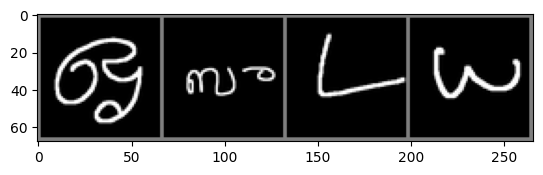

    ஓ    ஸு     ட     ய


In [ ]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(trainloader)
images, labels = next(dataiter) # Use next(dataiter) instead of dataiter.next()

imshow(torchvision.utils.make_grid(images[:4]))
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [ ]:
def initialize_weights(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight)
        nn.init.zeros_(m.bias)

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 16, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(16)
        self.pool1 = nn.MaxPool2d(2, 2)

        self.conv3 = nn.Conv2d(16, 32, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(32)
        self.conv4 = nn.Conv2d(32, 32, 3, padding=1)
        self.bn4 = nn.BatchNorm2d(32)

        self.conv5 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn5 = nn.BatchNorm2d(64)
        self.conv6 = nn.Conv2d(64, 64, 3, padding=1)
        self.bn6 = nn.BatchNorm2d(64)

        self.fc1 = nn.Linear(64 * 8 * 8, 1024)
        self.bn7 = nn.BatchNorm1d(1024)
        self.fc2 = nn.Linear(1024, 512)
        self.bn8 = nn.BatchNorm1d(512)
        self.fc3 = nn.Linear(512, 156)

    def forward(self, x):

        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool1(F.relu(self.bn2(self.conv2(x))))

        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool1(F.relu(self.bn4(self.conv4(x))))

        x = F.relu(self.bn5(self.conv5(x)))
        x = self.pool1(F.relu(self.bn6(self.conv6(x))))

        x = x.view(-1, 64 * 8 * 8)
        x = F.relu(self.bn7(self.fc1(x)))
        x = F.relu(self.bn8(self.fc2(x)))
        x = self.fc3(x)
        return x

net = Net()
net.apply(initialize_weights)
net.to(device)

Net(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), weight_decay=0.003, lr=0.001)

In [ ]:
x = []
train_loss = []
val_loss = []
train_accuracy = []
val_accuracy = []
fig, axs = plt.subplots(3)

x_two = []
running_losses = []

for epoch in range(30):
    x.append(epoch)

    curr_train_loss = 0.0
    train_total = 0
    train_correct = 0
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()

        outputs = net(inputs)
        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        curr_train_loss += loss.item()

        running_loss += loss.item()
        if i % 100 == 99:
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 100))
            running_losses.append(running_loss)
            x_two.append(epoch + i * 64 / len(trainset))
            running_loss = 0.0

    train_loss.append(curr_train_loss / len(trainset) * 64)
    train_accuracy.append(100 * train_correct / train_total)

    val_correct = 0
    val_total = 0
    curr_val_loss = 0.0
    with torch.no_grad():
        for data in valloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
            curr_val_loss += criterion(outputs, labels).item()
    val_loss.append(curr_val_loss / len(valset) * 64)
    val_accuracy.append(100 * val_correct / val_total)

    print('EPOCH ' + str(epoch + 1))
    print('Training loss: ' + str(train_loss[-1]))
    print('Training accuracy: ' + str(train_accuracy[-1]) + "%")
    print('Validation loss: ' + str(val_loss[-1]))
    print('Validation accuracy: ' + str(val_accuracy[-1]) + "%")
    print('----------------------------------------------------')


    axs[0].plot(x, train_loss, 'r-', val_loss, 'b-')
    axs[1].plot(x, train_accuracy, 'r-', val_accuracy, 'b-')
    axs[2].plot(x_two, running_losses)

<ipython-input-5-e367c21ebad4>:11: DeprecationWarning: Please import `center_of_mass` from the `scipy.ndimage` namespace; the `scipy.ndimage.measurements` namespace is deprecated and will be removed in SciPy 2.0.0.
  com = ndimage.measurements.center_of_mass(arr)


[1,   100] loss: 2.490
[1,   200] loss: 1.069
[1,   300] loss: 0.768
[1,   400] loss: 0.620
[1,   500] loss: 0.576
[1,   600] loss: 0.561
EPOCH 1
Training loss: 0.9888141058454832
Training accuracy: 75.398313027179%
Validation loss: 0.5084919336339102
Validation accuracy: 86.93893656900464%
----------------------------------------------------
[2,   100] loss: 0.434
[2,   200] loss: 0.462
[2,   300] loss: 0.465
[2,   400] loss: 0.464
[2,   500] loss: 0.450
[2,   600] loss: 0.443
EPOCH 2
Training loss: 0.4532405751144175
Training accuracy: 88.82257189365166%
Validation loss: 0.4587593876399431
Validation accuracy: 88.93163657886949%
----------------------------------------------------
[3,   100] loss: 0.389
[3,   200] loss: 0.411
[3,   300] loss: 0.430
[3,   400] loss: 0.402
[3,   500] loss: 0.425
[3,   600] loss: 0.418
EPOCH 3
Training loss: 0.4144789367577558
Training accuracy: 90.07546983672866%
Validation loss: 0.4504786454985642
Validation accuracy: 88.4778534083062%
---------------

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Inference code
dataiter = iter(testloader)
data_thing = dataiter.next()
images, labels = data_thing[0].to(device), data_thing[1].to(device)

# Show some sample images
imgs = images.cpu()
imshow(torchvision.utils.make_grid(imgs[:4]))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))


In [ ]:
outputs = net(images[:4])
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

In [ ]:

# Accuracy calculation
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %f %%' % (100 * correct / total))


In [ ]:
# Save the model to Google Drive
model_path = '/content/drive/My Drive/tamil_net.pt'
torch.save(net.state_dict(), model_path)
print(f'Model saved to {model_path}')